In [1]:
## Import Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [2]:
## Data Preparations
df_smeared = pd.read_csv("combined_dataset_withz.csv")  # Nominal events on BA classifier
df_fixedz = pd.read_csv("combined_dataset_z+1.csv")

X_train = df_smeared.drop(columns=['event', 'label', 'z']).values
y_train = df_smeared['label'].values
X_test = df_fixedz.drop(columns=['event', 'label', 'z']).values
y_test = df_fixedz['label'].values

print('Training sets size:', X_train.shape)
print('Test sets size:', X_test.shape)

Training sets size: (199504, 14)
Test sets size: (199504, 14)


In [3]:
## Standarlize the data set
# Initialize a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on training data only
# This computes mean and std using training set (x-mu)/std
scaler.fit(X_train)

# Transform training data
X_train_scaled = scaler.transform(X_train)

# Transform test data using SAME scaling parameters
X_test_scaled = scaler.transform(X_test)

In [4]:
## Define Keras Model
model = Sequential()
model.add(Input(shape=(14,)))  
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [5]:
## Compile the Keras Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fit the Keras Model !!!(May use classweight for different data size)
history = model.fit(
    X_train_scaled,  # Input (standarlized) features
    y_train,   # Target labels (0 or 1)
    epochs=50,  # Number of full passes over the training data
    batch_size=10,  # number of samples per gradient update
    verbose=2  # One line per epochs 
)

Epoch 1/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7141 - loss: 0.5612
Epoch 2/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7246 - loss: 0.5485
Epoch 3/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7261 - loss: 0.5466
Epoch 4/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7265 - loss: 0.5453
Epoch 5/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7271 - loss: 0.5440
Epoch 6/50
19951/19951 - 25s - 1ms/step - accuracy: 0.7273 - loss: 0.5435
Epoch 7/50
19951/19951 - 41s - 2ms/step - accuracy: 0.7277 - loss: 0.5429
Epoch 8/50
19951/19951 - 25s - 1ms/step - accuracy: 0.7277 - loss: 0.5425
Epoch 9/50
19951/19951 - 25s - 1ms/step - accuracy: 0.7279 - loss: 0.5419
Epoch 10/50
19951/19951 - 25s - 1ms/step - accuracy: 0.7280 - loss: 0.5414
Epoch 11/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7286 - loss: 0.5410
Epoch 12/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7287 - loss: 0.5405
Epoch 13/50
19951/19951 - 26s - 1ms/step - accuracy: 0.7290 - loss: 0.5404
Epoch 14/50
19951/19951 - 25s - 1m

In [6]:
## Make predictions on the test set
y_pred_probs = model.predict(X_test_scaled)  # Use "Test" dataset for prediction
y_pred_labels = (y_pred_probs > 0.5).astype(int)  # Convert probabilities into class label (>0.5 -> 1, <0.5 -> 0) 

## Evaluate the model accuracy on test dataset
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {accuracy:.4f}')

6235/6235 ━━━━━━━━━━━━━━━━━━━━ 5s 750us/step
Test Accuracy: 0.7243


In [7]:
# Data Storage
MODEL_NAME = "DA"        
Z_TEST = 1.0             # Current fixed z value

# File path：outputs/BA/z_+0.8/
out_dir = f"outputs/{MODEL_NAME}/z_{Z_TEST:+.1f}"
os.makedirs(out_dir, exist_ok=True)

# Save predictions results
np.savez_compressed(
    os.path.join(out_dir, "preds.npz"),
    y_test=y_test.astype(int),
    y_score=y_pred_probs.ravel().astype(float)
)

# Save ROC results
fpr, tpr, thr = roc_curve(y_test, y_pred_probs.ravel())
rocAUC = auc(fpr, tpr)
np.savez_compressed(
    os.path.join(out_dir, "roc.npz"),
    fpr=fpr, tpr=tpr, thr=thr, auc=np.array([rocAUC], dtype=float)
)

print(f"Result saved in {out_dir}, AUC={rocAUC:.3f}")

结果已保存到 outputs/DA/z_+1.0, AUC=0.819


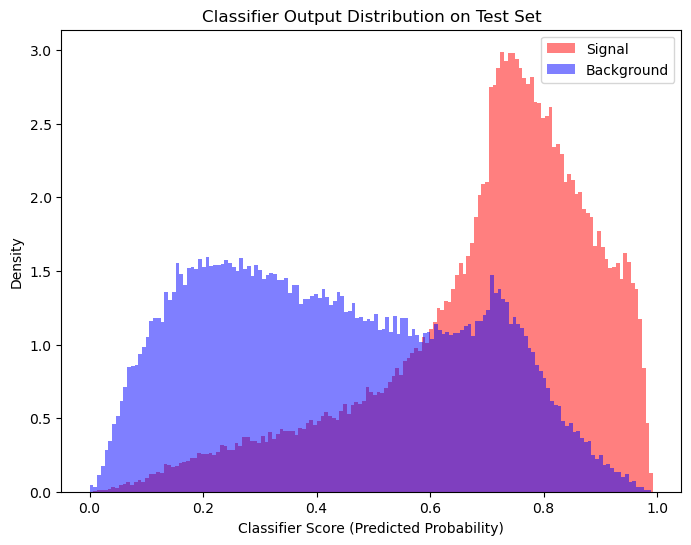

In [8]:
## Plot classfier output distribution
signal_scores = y_pred_probs[y_test == 1]
background_scores = y_pred_probs[y_test == 0]

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(signal_scores, bins=150, alpha=0.5, label='Signal', density=True, color='red')
plt.hist(background_scores, bins=150, alpha=0.5, label='Background', density=True, color='blue')

# Add labels and title
plt.xlabel('Classifier Score (Predicted Probability)')
plt.ylabel('Density')
plt.title('Classifier Output Distribution on Test Set')
plt.legend()
plt.savefig("Score_histogram_DA_Z=-1.0.pdf")
plt.show()

In [ ]:
## Plot ROC curve, calculate AUC
# Acquire prediction probability on signals
y_pred_probs = model.predict(X_test_scaled).ravel()

# Calculate FPR, TPR and corresponding thersholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')  # Show random model line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

6235/6235 ━━━━━━━━━━━━━━━━━━━━ 4s 659us/step


In [9]:
## Save Results
np.save("y_test_augmented.npy", y_test)
np.save("y_pred_probs_augmented.npy", y_pred_probs)